In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

In [1]:
db_config = {
# Удалил в целях безопасности
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('MONTH', creation_date)::date month_date,
       SUM(views_count) total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('YEAR', creation_date) = '2008-01-01'
GROUP BY DATE_TRUNC('MONTH', creation_date)
ORDER BY total_views DESC
'''

# выполните запрос
sample_df_one = pd.read_sql_query(query, con=engine) 

In [7]:
sample_df_one

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Вывод** 

Самый просматриваемый месяц - сентябрь, после него октябрь, потом ноябрь, затем август, июль. Возможно, это связано с тем, что stackoverflow начал свою работу в 2008 году и каждый месяц становился популярнее, и из-за этого так растут просмотры. 


# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [8]:
# напишите запрос

query = '''
SELECT display_name,
       COUNT(DISTINCT user_id)
FROM
    (SELECT p.creation_date post_date,
            u.creation_date user_date,
            display_name,
            DATE_TRUNC('DAY', u.creation_date) + INTERVAL '1 month' new_date,
            p.user_id
    FROM stackoverflow.users u
    RIGHT JOIN stackoverflow.posts p ON u.id = p.user_id
    WHERE post_type_id = 2) full_df
WHERE post_date BETWEEN user_date AND new_date
GROUP BY display_name
HAVING COUNT(*) > 100 
'''

# выполните запрос
sample_df_two = pd.read_sql_query(query, con=engine) 

In [9]:
sample_df_two

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


**Вывод**


Есть повторяющиеся имена пользователей, т.е. под одним ником много людей.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [10]:
# напишите запрос

query = '''
SELECT DATE_TRUNC('MONTH', p.creation_date)::date month_name,
       COUNT(*) count
FROM stackoverflow.users u
RIGHT JOIN stackoverflow.posts p ON u.id = p.user_id
WHERE u.id IN (SELECT u.id
              FROM stackoverflow.users u
              RIGHT JOIN stackoverflow.posts p ON u.id = p.user_id
              WHERE DATE_TRUNC('MONTH', p.creation_date)::date = '2008-12-01')
  AND DATE_TRUNC('MONTH', u.creation_date)::date = '2008-09-01'
GROUP BY DATE_TRUNC('MONTH', p.creation_date)
ORDER BY month_name DESC
'''


# выполните запрос
sample_df_three = pd.read_sql_query(query, con=engine) 

In [11]:
sample_df_three

,month_name,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Вывод**

Видно, что есть аномалия: у пользователей, которые зарегистрировались в сентябре, имеют посты в августе.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [12]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY user_id, creation_date) cumulative_count
FROM stackoverflow.posts
'''

# выполните запрос
sample_df_four = pd.read_sql_query(query, con=engine) 

In [13]:
sample_df_four

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [14]:
# напишите запрос

query = '''
SELECT DISTINCT user_id,
       AVG(count_post) OVER(PARTITION BY user_id) avg_daily
FROM
    (SELECT user_id,
            DATE_TRUNC('DAY', creation_date)::date day_number,
            COUNT(*) count_post
    FROM stackoverflow.posts
    WHERE user_id IN (SELECT user_id
                      FROM stackoverflow.posts
                      WHERE DATE_TRUNC('MONTH', creation_date)::date = '2008-08-01'
                      GROUP BY user_id
                      HAVING COUNT(id) > 120)
      AND DATE_TRUNC('MONTH', creation_date)::date = '2008-08-01'
    GROUP BY user_id, DATE_TRUNC('DAY', creation_date)::date) data_count
ORDER BY avg_daily
'''

# выполните запрос
sample_df_five = pd.read_sql_query(query, con=engine) 

In [15]:
sample_df_five

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [16]:
# напишите запрос
query = '''
WITH distinct_date AS 
    (SELECT user_id,
            COUNT(DISTINCT DATE_TRUNC('DAY', creation_date)::date) count_days
     FROM stackoverflow.posts
     WHERE DATE_TRUNC('DAY', creation_date)::date BETWEEN '2008-12-01' AND '2008-12-07'
     GROUP BY user_id)
      
SELECT ROUND(AVG(count_days))
FROM distinct_date
'''

# выполните запрос
sample_df_six = pd.read_sql_query(query, con=engine) 

In [17]:
sample_df_six

,round
0,2.0


**Вывод**

В среднем пользователь делал 2 поста в день за период с 1 по 7 декабря 2008 года.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [19]:
# напишите запрос

query = '''
WITH date_df AS (SELECT user_id,
                        creation_date,
                        EXTRACT(MONTH FROM LAG(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date)) AS new_date
                 FROM stackoverflow.posts)
            
SELECT user_id,
       creation_date,
       CASE
            WHEN new_date = 1 THEN 'January'
            WHEN new_date = 2 THEN 'February'
            WHEN new_date = 3 THEN 'March'
            WHEN new_date = 4 THEN 'April'
            WHEN new_date = 5 THEN 'May'
            WHEN new_date = 6 THEN 'June'
            WHEN new_date = 7 THEN 'July'
            WHEN new_date = 8 THEN 'August'
            WHEN new_date = 9 THEN 'September'
            WHEN new_date = 10 THEN 'October'
            WHEN new_date = 11 THEN 'November'
            WHEN new_date = 12 THEN 'December'
       END as second_last_month
FROM date_df
'''

# выполните запрос
sample_df_seven = pd.read_sql_query(query, con=engine) 

In [20]:
sample_df_seven

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [23]:
# напишите запрос

query = '''
WITH session AS (SELECT DISTINCT
                        DATE_TRUNC('MONTH', creation_date) session_date,
                        user_id
                 FROM stackoverflow.posts
                 GROUP BY user_id,
                          DATE_TRUNC('MONTH', creation_date)),
     profile_new AS (SELECT DISTINCT
                            user_id,
                            cohort_dt,
                            COUNT(user_id) OVER(PARTITION BY cohort_dt) cohort_users_cnt
                     FROM
                          (SELECT DISTINCT
                                  user_id,
                                  MIN(DATE_TRUNC('MONTH', creation_date)) OVER(PARTITION BY user_id) cohort_dt
                           FROM stackoverflow.posts) profile)    
                                 
SELECT DISTINCT
       cohort_dt::date,
       session_date::date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM session s
RIGHT JOIN profile_new p ON s.user_id = p.user_id
GROUP BY 1,
         2,
         4
ORDER BY cohort_dt, session_date
'''

# выполните запрос

sample_df_eight = pd.read_sql_query(query, con=engine) 

In [24]:
sample_df_eight

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


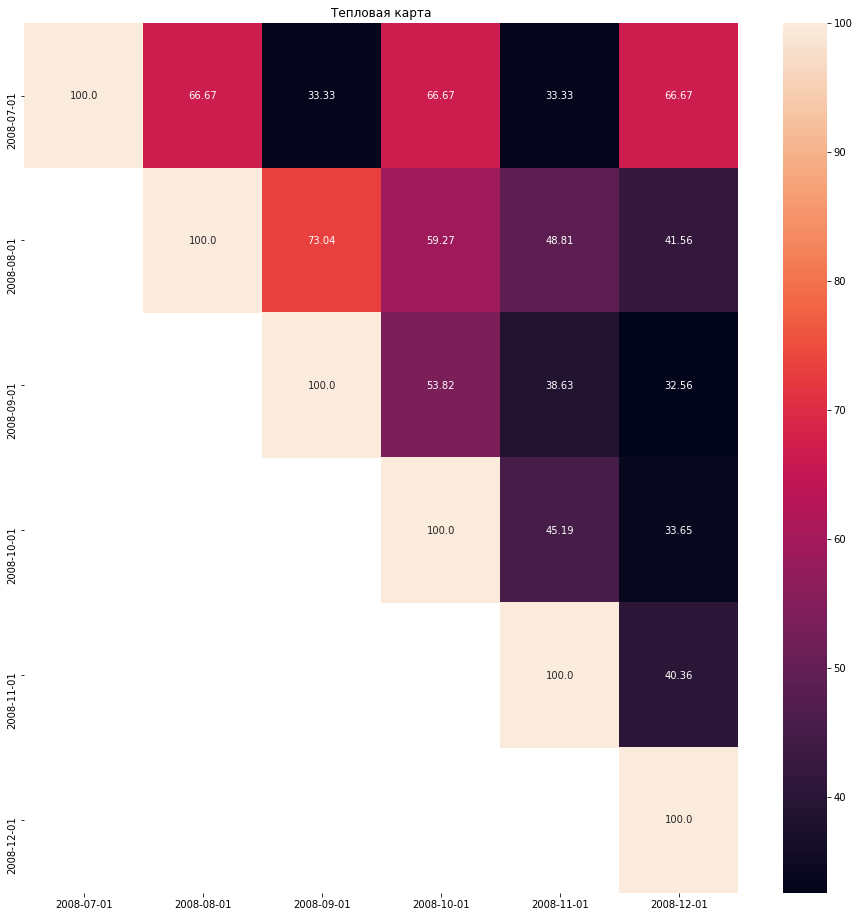

In [25]:
# построил тепловую карту Retention Rate

retention = sample_df_eight.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x) for x in retention.index]
retention.columns = [str(x) for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show() 

**Вывод**

В когорте, которая 11 января - самый маленький Retention Rate на след. месяц, а 8 января - самый большой(у них очень большой отток). У всех когорт, кроме той, которые сделали 1 пост в июле с каждым месяцем отток понижался, а у когорты июля он то понижался, то повышался(т.е. пользователи возвращались :), чтобы снова попробовать).

Какие могут быть причины большого оттока? Возможно, не понравился сайт, все таки 2008 год, пользователи пришли, попробовали и им просто не понравилось(на данный момент, предполагаю, что у них отток меньше, чем тогда)

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [26]:
# напишите запрос
query = '''
WITH count_p AS (SELECT DISTINCT
                        EXTRACT(MONTH FROM creation_date)::int creation_month,
                        COUNT(*) OVER(PARTITION BY EXTRACT(MONTH FROM creation_date)) posts_count
                 FROM stackoverflow.posts
                 WHERE DATE_TRUNC('DAY', creation_date) BETWEEN '2008-09-01' AND '2008-12-31')
                 
SELECT creation_month,
       posts_count, 
       ROUND(((posts_count - LAG(posts_count) OVER(ORDER BY creation_month))::numeric / LAG(posts_count) OVER(ORDER BY creation_month)) * 100, 2) percentage
FROM count_p

'''

# выполните запрос
sample_df_nine = pd.read_sql_query(query, con=engine) 

In [27]:
sample_df_nine

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


<Figure size 864x720 with 0 Axes>

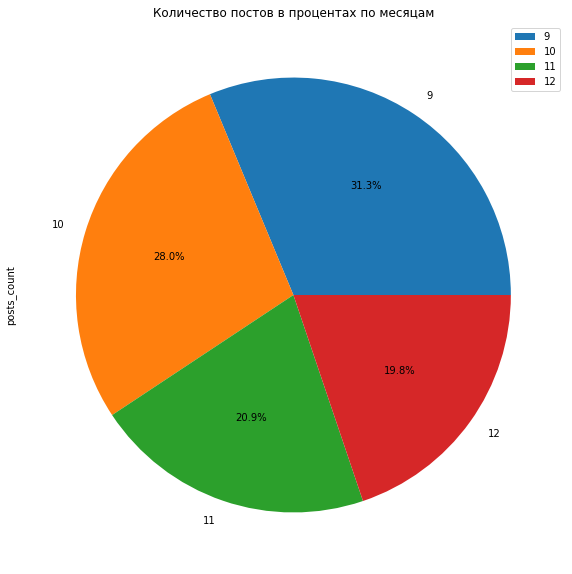

In [28]:
# постройте круговую диаграмму с количеством постов по месяцам
plt.figure(figsize=(12, 10));
sample_df_nine.plot.pie(y='posts_count', autopct="%.1f%%", labels=sample_df_nine['creation_month'], figsize=(12,10));
plt.title('Количество постов в процентах по месяцам');

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [29]:
# напишите запрос

query = '''
SELECT DISTINCT
       EXTRACT(WEEK FROM creation_date)::int week_creation,
       MAX(creation_date) OVER(PARTITION BY EXTRACT(WEEK FROM creation_date)) creation_date
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id
                  FROM
                      (SELECT DISTINCT
                              user_id,
                              COUNT(*) OVER(PARTITION BY user_id) count_posts
                       FROM stackoverflow.posts
                       ORDER BY count_posts DESC) user_df
                  ORDER BY count_posts DESC
                  LIMIT 1)
  AND DATE_TRUNC('MONTH', creation_date) = '2008-10-01'
            
'''

# выполните запрос
sample_df_ten = pd.read_sql_query(query, con=engine) 

In [30]:
sample_df_ten

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
